In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model

from sklearn import preprocessing

from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train["SalePrice"]

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, dtype: int64

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Getting a list of NaN valued cols
train.isnull().sum()[train.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
obj_cols = list(train.select_dtypes(include=["object"]).columns)
obj_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [7]:
numeric_cols = list(train.select_dtypes(exclude=["object"]).columns)
del numeric_cols[-1]
numeric_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [8]:
train["FinishedArea"] = train["TotalBsmtSF"] - train["BsmtUnfSF"]

In [9]:
cor_dict = dict(train.corr()["SalePrice"] > 0.5)
train[[i for i in cor_dict if cor_dict[i] == True]].corr()

,TotalBsmtSF,OverallQual,GarageCars,GarageArea,YearRemodAdd,TotRmsAbvGrd,YearBuilt,SalePrice,GrLivArea,1stFlrSF,FullBath
TotalBsmtSF,1.000000,0.537808,0.434585,0.486665,0.291066,0.285573,0.391452,0.613581,0.454868,0.819530,0.323722
OverallQual,0.537808,1.000000,0.600671,0.562022,0.550684,0.427452,0.572323,0.790982,0.593007,0.476224,0.550600
GarageCars,0.434585,0.600671,1.000000,0.882475,0.420622,0.362289,0.537850,0.640409,0.467247,0.439317,0.469672
GarageArea,0.486665,0.562022,0.882475,1.000000,0.371600,0.337822,0.478954,0.623431,0.468997,0.489782,0.405656
YearRemodAdd,0.291066,0.550684,0.420622,0.371600,1.000000,0.191740,0.592855,0.507101,0.287389,0.240379,0.439046
TotRmsAbvGrd,0.285573,0.427452,0.362289,0.337822,0.191740,1.000000,0.095589,0.533723,0.825489,0.409516,0.554784
YearBuilt,0.391452,0.572323,0.537850,0.478954,0.592855,0.095589,1.000000,0.522897,0.199010,0.281986,0.468271
SalePrice,0.613581,0.790982,0.640409,0.623431,0.507101,0.533723,0.522897,1.000000,0.708624,0.605852,0.560664
GrLivArea,0.454868,0.593007,0.467247,0.468997,0.287389,0.825489,0.199010,0.708624,1.000000,0.566024,0.630012
1stFlrSF,0.819530,0.476224,0.439317,0.489782,0.240379,0.409516,0.281986,0.605852,0.566024,1.000000,0.380637


In [10]:
train["SalePrice"]

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, dtype: int64

In [11]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_X, train_Y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

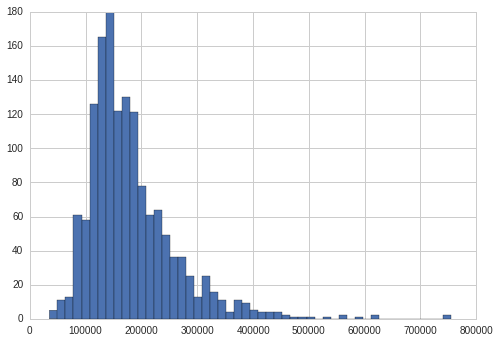

In [12]:
with sns.axes_style("whitegrid"):
    train.SalePrice.hist(bins=50)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


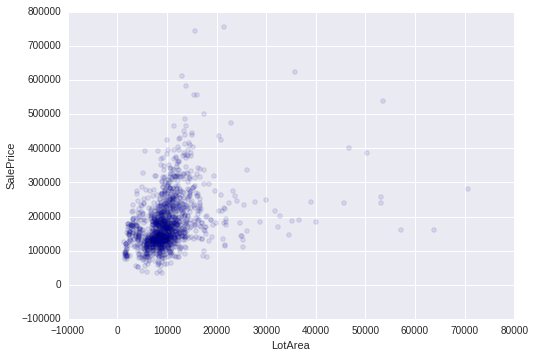

In [13]:
train = train[train["LotArea"] < 100000]

feat = "LotArea"
def scat(train_2std, feat, res):
    plt.scatter(train_2std[feat], train_2std[res], lw=1, alpha=.1)
    plt.xlabel(feat)
    plt.ylabel(res)
        
scat(train, feat, "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


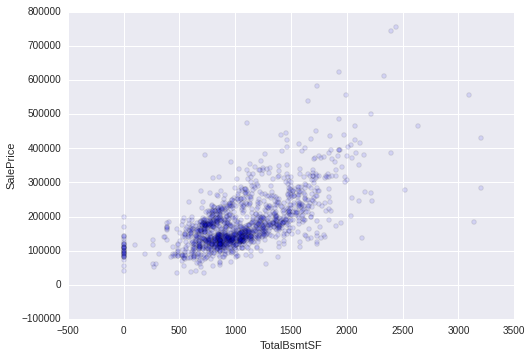

In [14]:
train = train[train["TotalBsmtSF"] < 6000]
scat(train, "TotalBsmtSF", "SalePrice")


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


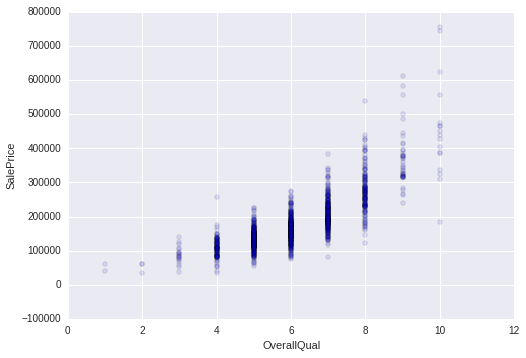

In [15]:
scat(train, "OverallQual", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


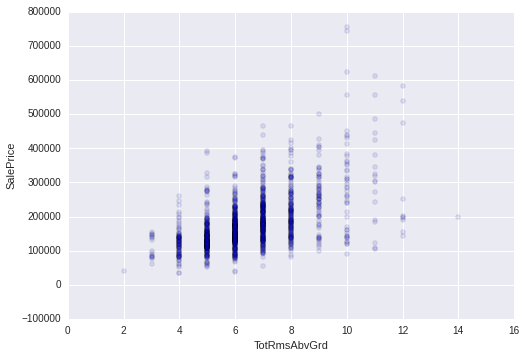

In [16]:
scat(train, "TotRmsAbvGrd", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


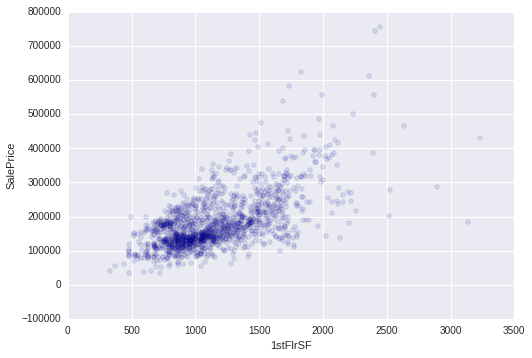

In [17]:
scat(train, "1stFlrSF", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


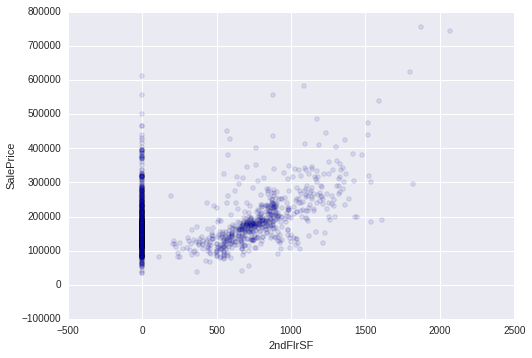

In [18]:
scat(train, "2ndFlrSF", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


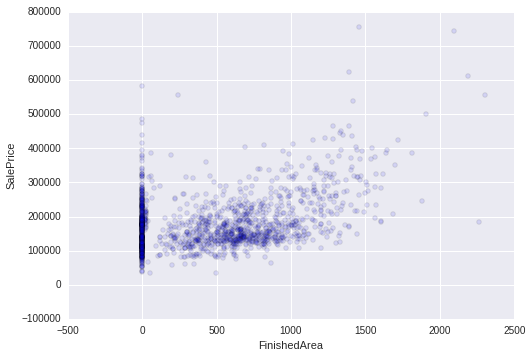

In [19]:
scat(train, "FinishedArea", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


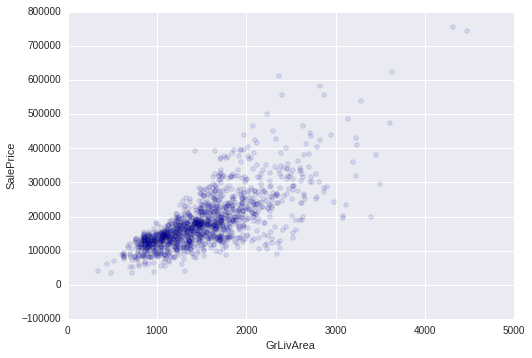

In [20]:
train = train[train["GrLivArea"] < 4600]
scat(train, "GrLivArea", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


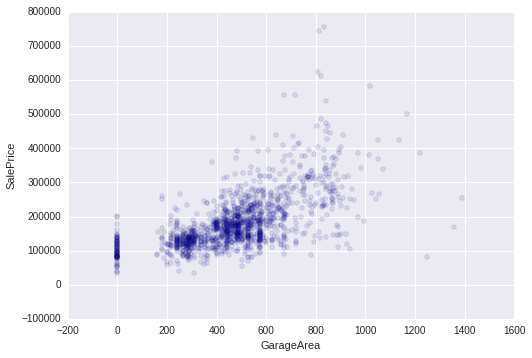

In [21]:
scat(train, "GarageArea", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


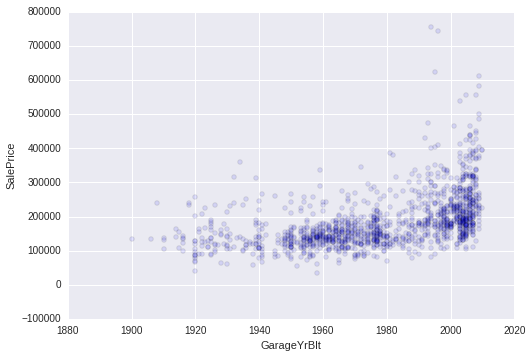

In [22]:
scat(train, "GarageYrBlt", "SalePrice")

In [23]:
train["QualYear"] = train["OverallQual"] / train["YearBuilt"]

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


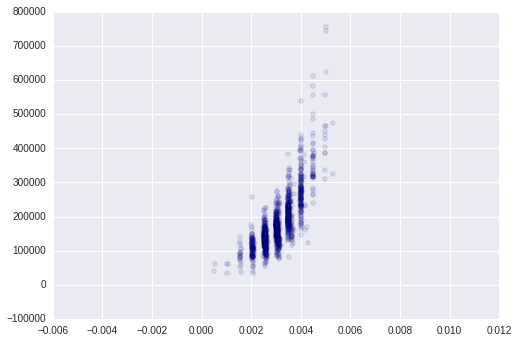

In [24]:
plt.scatter(train["QualYear"], train["SalePrice"], lw=1, alpha=.1)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


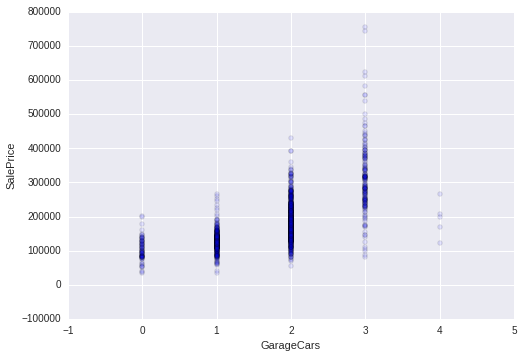

In [25]:
scat(train, "GarageCars", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


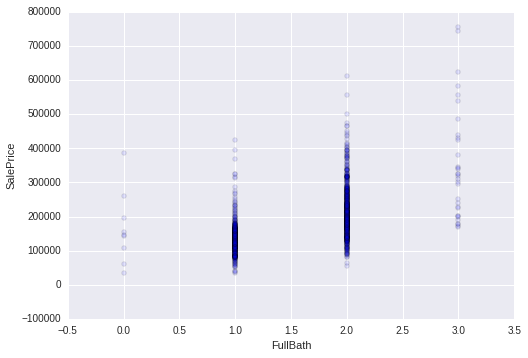

In [26]:
scat(train, "FullBath", "SalePrice")

In [27]:
#Prepping data for linear regression

test = pd.read_csv("test.csv")


dummy_df_train = pd.get_dummies(train[obj_cols])
ls_dummy_cols = list(dummy_df_train.columns)

dummy_df_test = pd.get_dummies(test[obj_cols])

ls_dummy_cols = list(set(list(dummy_df_train.columns)) & set(list(dummy_df_test.columns)))

train = pd.concat([train, dummy_df_train], axis=1)

test = pd.concat([test, dummy_df_test], axis=1)

print(test["Id"])

"""
test["MSZoning_norm"] = test["MSZoning"].map(ls_map[0])
test["Neighborhood_norm"] = test["Neighborhood"].map(ls_map[1])
test["ExterQual_norm"] = test["ExterQual"].map(ls_map[2])
test["ExterCond_norm"] = test["ExterCond"].map(ls_map[3])
"""

#ls_params = ["LotArea", "OverallQual", "TotRmsAbvGrd", "GarageArea", 
#            "1stFlrSF", "2ndFlrSF", "YearBuilt", "FinishedArea", "PoolArea",  "GrLivArea"]
numeric_cols.append("QualYear")
numeric_cols.extend(ls_dummy_cols)
ls_params = numeric_cols
#kenel
#ls_params =["LotArea","TotalBsmtSF", "OverallQual", "TotRmsAbvGrd", "GarageArea",
#             "1stFlrSF", "2ndFlrSF", "YearBuilt", "YearRemodAdd", "GrLivArea", "GarageYrBlt"]




test["FinishedArea"] = test["TotalBsmtSF"] - test["BsmtUnfSF"]

test["QualYear"] = test["OverallQual"] / test["YearBuilt"]

#print(ls_params)

test_X = test[ls_params].fillna(0)
train_X = train[ls_params].fillna(0)
train_Y = np.log(train["SalePrice"])



0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, dtype: int64


In [28]:
test_X.isnull().sum()[test_X.isnull().sum() > 0]

Series([], dtype: int64)

In [29]:
test["Id"]

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, dtype: int64

In [30]:
np.any(np.isnan(train_Y))

False

In [31]:
linreg = linear_model.LinearRegression()

In [32]:
linreg.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
pred_Y = linreg.predict(test_X)

In [34]:
linreg.score(train_X, train_Y)

0.94839802419075114

In [35]:
scores = cross_val_score(linreg, train_X, train_Y, cv=10)
scores

array([ 0.88561492,  0.92701331,  0.91084722,  0.88828765,  0.89000857,
        0.89351764,  0.9023876 ,  0.92940098,  0.91913078,  0.89632203])

In [36]:
ridgereg = linear_model.RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv=5)
ridgereg.fit(train_X, train_Y)
pred_Y_ridge = ridgereg.predict(test_X)
ridgereg.score(train_X, train_Y)

0.94007905758835253

In [37]:
rmse_cv(ridgereg).mean()

0.11433713970800277

In [38]:
scores_ridge = cross_val_score(ridgereg, train_X, train_Y, cv=10)
scores_ridge

array([ 0.89926737,  0.93809601,  0.93801387,  0.90470821,  0.90585458,
        0.91955751,  0.91175162,  0.9359417 ,  0.93567195,  0.90925266])

In [39]:
lasso = linear_model.LassoCV(alphas=[1, 0.1, 0.001, 0.0005], cv=10)
lasso.fit(train_X, train_Y)
pred_Y_lasso = lasso.predict(test_X)
lasso.score(train_X, train_Y)

/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.93746438981334357

In [40]:
rmse_cv(lasso).mean()

/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You migh

0.111240549617768

In [41]:
df_out = pd.DataFrame({"Id":test["Id"], "SalePrice":pred_Y})

In [42]:
df_out.to_csv("withoutcleaningQY.csv", index=False)

In [43]:
pred_Y_res = linreg.predict(train_X)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


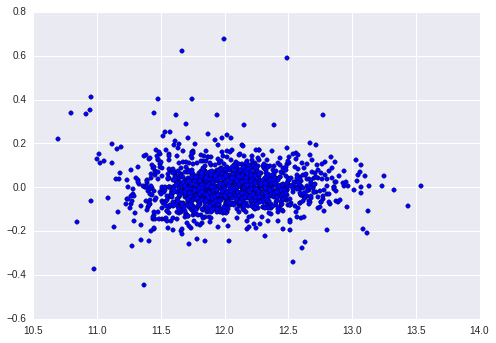

In [44]:
plt.scatter(pred_Y_res, pred_Y_res - train_Y)

In [45]:
df_out_ridge = pd.DataFrame({"Id":test["Id"], "SalePrice":np.exp(pred_Y_ridge)})
df_out_ridge.to_csv("ridged.csv", index=False)

In [46]:
test["Id"]

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, dtype: int64

In [47]:
#pred_Y_lasso[pred_Y_lasso < 0] = 0
df_out_lasso = pd.DataFrame({"Id":test["Id"].astype("int"), "SalePrice":np.exp(pred_Y_lasso)})
df_out_lasso.to_csv("lasso.csv", index=False)

(array([  1.13700000e+03,   2.88000000e+02,   3.10000000e+01,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   42163.99541273,   215827.66660815,   389491.33780358,
          563155.008999  ,   736818.68019443,   910482.35138985,
         1084146.02258527,  1257809.6937807 ,  1431473.36497612,
         1605137.03617155,  1778800.70736697]),
 <a list of 10 Patch objects>)

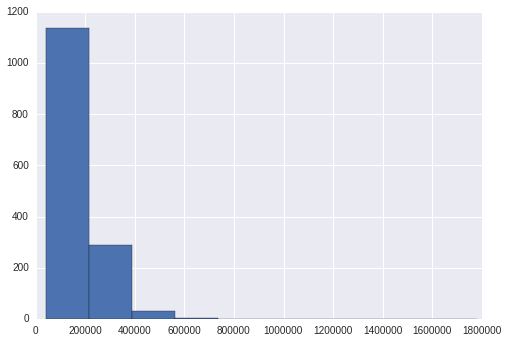

In [48]:
#pred_Y_lasso_res = lasso.predict(train_X)
plt.hist(np.exp(pred_Y_lasso))